In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, callbacks
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
import joblib
import warnings
warnings.filterwarnings('ignore')



In [ ]:
class IndiaTouristSafetyProfiler:
    def  __init__(self):
        self.health_encoder = MultiLabelBinarizer()
        self.gender_encoder = OneHotEncoder(drop="first", sparse_output=False)
        self.location_encoder = OneHotEncoder(sparse_output=False)
        self.feature_scaler = MinMaxScaler(feature_range=(0, 1))

        # Models
        self.neural_model = None
        self.rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

        # India-specific data
        self.india_locations = None
        self.location_risk_scores = None

    def initialize_india_locations(self):
        """Initialize Indian tourist locations with their base risk scores"""
        self.india_locations = {
            # Major Cities (Lower Risk)
            "Mumbai": 0.25, "Delhi": 0.35, "Bangalore": 0.20, "Chennai": 0.25,
            "Kolkata": 0.30, "Hyderabad": 0.22, "Pune": 0.20, "Ahmedabad": 0.28,
            "Jaipur": 0.30, "Lucknow": 0.32, "Kanpur": 0.35, "Nagpur": 0.25,

            # Tourist Destinations (Variable Risk)
            "Goa": 0.15, "Kerala": 0.18, "Agra": 0.30, "Varanasi": 0.40,
            "Rishikesh": 0.25, "Manali": 0.35, "Shimla": 0.20, "Darjeeling": 0.30,
            "Udaipur": 0.25, "Jodhpur": 0.35, "Pushkar": 0.30, "McLeod Ganj": 0.25,

            # Hill Stations (Moderate to High Risk due to terrain/weather)
            "Ladakh": 0.65, "Spiti": 0.70, "Kasol": 0.45, "Tosh": 0.55,
            "Malana": 0.60, "Kedarnath": 0.75, "Badrinath": 0.70, "Hemkund": 0.80,
            "Valley of Flowers": 0.65, "Roopkund": 0.85, "Har ki Dun": 0.60,

            # Adventure/Remote Locations (Higher Risk)
            "Leh": 0.60, "Kargil": 0.75, "Zanskar": 0.80, "Nubra Valley": 0.70,
            "Pangong Tso": 0.65, "Tso Moriri": 0.75, "Chadar Trek": 0.90,
            "Markha Valley": 0.70, "Stok Kangri": 0.85, "Pin Parvati": 0.80,

            # Wildlife/Forest Areas (Moderate Risk)
            "Jim Corbett": 0.40, "Ranthambore": 0.35, "Kaziranga": 0.50,
            "Bandhavgarh": 0.45, "Kanha": 0.40, "Sundarbans": 0.60,
            "Periyar": 0.35, "Bandipur": 0.40, "Nagarhole": 0.38,

            # Coastal Areas
            "Andaman": 0.30, "Nicobar": 0.55, "Lakshadweep": 0.25,
            "Gokarna": 0.20, "Vashisht": 0.30, "Hampi": 0.25,

            # Religious/Pilgrimage Sites
            "Haridwar": 0.35, "Amarnath": 0.80, "Kailash Mansarovar": 0.95,
            "Char Dham": 0.70, "Tirupati": 0.30, "Shirdi": 0.25,
            "Ajmer": 0.30, "Bodh Gaya": 0.35, "Kashi": 0.40,

            # Northeast India (Higher risk due to remoteness/permits)
            "Tawang": 0.65, "Ziro": 0.55, "Majuli": 0.50, "Cherrapunji": 0.45,
            "Mawlynnong": 0.40, "Dzukou": 0.60, "Loktak": 0.50
        }

        self.location_risk_scores = self.india_locations

    def generate_india_tourist_dataset(self, n_samples=5000):
        """Generate synthetic dataset for India tourist safety"""
        np.random.seed(42)
        random.seed(42)

        self.initialize_india_locations()

        # Pools for Indian context
        genders = ["Male", "Female"]
        tourist_types = ["Indian", "Foreign"]

        # Health conditions relevant to travel in India
        conditions_pool = [
            "none", "asthma", "diabetes", "hypertension", "heart_disease",
            "mobility_issues", "allergies", "chronic_medication", "elderly_frail"
        ]

        # Indian locations
        locations = list(self.india_locations.keys())

        rows = []
        for _ in range(n_samples):
            # Basic demographics
            age = int(np.random.beta(2, 3) * 52 + 18)  # 18-70, skewed younger
            gender = random.choice(genders)
            tourist_type = np.random.choice(tourist_types, p=[0.7, 0.3])  # 70% Indian, 30% foreign

            # Group characteristics
            group_size = np.random.choice([1, 2, 3, 4, 5, 6], p=[0.2, 0.35, 0.2, 0.15, 0.07, 0.03])

            # Location selection (some locations more popular than others)
            if tourist_type == "Foreign":
                # Foreign tourists more likely to visit famous destinations
                popular_locations = ["Goa", "Kerala", "Agra", "Jaipur", "Delhi", "Mumbai",
                                   "Rishikesh", "Manali", "Ladakh", "Varanasi"]
                location = np.random.choice(
                    popular_locations if random.random() < 0.6 else locations
                )
            else:
                # Indian tourists have broader preferences
                location = random.choice(locations)

            location_base_risk = self.location_risk_scores[location]

            # Health conditions (age-dependent)
            if age < 30:
                n_conditions = np.random.choice([0, 1], p=[0.85, 0.15])
            elif age < 50:
                n_conditions = np.random.choice([0, 1, 2], p=[0.65, 0.30, 0.05])
            else:
                n_conditions = np.random.choice([0, 1, 2, 3], p=[0.4, 0.4, 0.15, 0.05])

            if n_conditions == 0:
                health_conditions = ["none"]
            else:
                available_conditions = [c for c in conditions_pool if c != "none"]
                if age > 60:
                    # Elderly more likely to have certain conditions
                    available_conditions.extend(["hypertension", "diabetes", "elderly_frail"])
                health_conditions = random.sample(available_conditions, min(n_conditions, len(available_conditions)))

            # Tourist type risk adjustment
            tourist_risk_multiplier = 1.2 if tourist_type == "Foreign" else 1.0

            rows.append([
                age, gender, group_size, location, location_base_risk,
                health_conditions,tourist_type,
                tourist_risk_multiplier
            ])

        columns = [
            'age', 'gender', 'group_size', 'location', 'location_base_risk',
            'health_conditions','tourist_type',
            'tourist_risk_multiplier'
        ]

        df = pd.DataFrame(rows, columns=columns)

        # Calculate comprehensive risk score
        df['risk_score'] = df.apply(self._calculate_india_risk_score, axis=1)

        return df


    def _calculate_india_risk_score(self, row):
        """Calculate comprehensive risk score for India tourism"""
        risk_factors = {}

        # Age risk (higher for very young and elderly)
        if row['age'] < 25:
            age_risk = 0.6
        elif row['age'] > 65:
            age_risk = 0.7
        else:
            age_risk = 0.3
        risk_factors['age'] = age_risk

        # Group size risk (solo travelers higher risk)
        if row['group_size'] == 1:
            group_risk = 0.7
        elif row['group_size'] == 2:
            group_risk = 0.4
        else:
            group_risk = 0.2
        risk_factors['group'] = group_risk

        # Gender risk
        gender_risk = 0.6 if row['gender'] == 'Female' else 0.3
        if row['gender'] == 'Female' and row['group_size'] == 1:
            gender_risk = 0.8  # Solo female travelers face higher risk
        risk_factors['gender'] = gender_risk

        # Health conditions risk
        health_severity = {
            "none": 0.0, "asthma": 0.4, "diabetes": 0.5, "hypertension": 0.4,
            "heart_disease": 0.8, "mobility_issues": 0.7, "allergies": 0.3,
            "chronic_medication": 0.5, "elderly_frail": 0.9
        }

        health_conditions = row['health_conditions']
        if isinstance(health_conditions, list):
            health_scores = [health_severity.get(condition, 0.0) for condition in health_conditions]
            health_risk = np.mean(health_scores) if health_scores else 0.0
        else:
            health_risk = 0.0
        risk_factors['health'] = health_risk

        # Location risk (directly from location safety score)
        location_risk = row['location_base_risk']
        risk_factors['location'] = location_risk

        # Tourist type risk
        tourist_multiplier = row['tourist_risk_multiplier']

        # Weighted combination
        weights = {
            'age': 0.17,
            'group': 0.20,
            'gender': 0.18,
            'health': 0.20,
            'location': 0.25,
        }

        base_risk = sum(weights[factor] * risk for factor, risk in risk_factors.items())

        # Apply tourist type multiplier
        final_risk = base_risk * tourist_multiplier

        # Add some noise and normalize
        final_risk += np.random.normal(0, 0.03)
        final_risk = np.clip(final_risk, 0, 1)

        return final_risk

    def preprocess_features(self, df):
        """Preprocess features for model training"""
        # Health condition encoding
        health_encoded = self.health_encoder.fit_transform(df['health_conditions'])

        # Gender encoding
        gender_encoded = self.gender_encoder.fit_transform(df[['gender']])

        # Tourist type encoding (Indian=0, Foreign=1)
        tourist_type_encoded = (df['tourist_type'] == 'Foreign').astype(int).values.reshape(-1, 1)

        # Numerical features
        numerical_features = df[['age', 'group_size', 'location_base_risk']].values

        # Interaction features
        # Solo female risk
        solo_female = ((df['gender'] == 'Female') & (df['group_size'] == 1)).astype(int).values.reshape(-1, 1)

        # Elderly with health issues
        elderly_health = ((df['age'] > 60) & (health_encoded.sum(axis=1) > 0)).astype(int).values.reshape(-1, 1)

        # Foreign tourist in high-risk location
        foreign_high_risk = ((df['tourist_type'] == 'Foreign') & (df['location_base_risk'] > 0.5)).astype(int).values.reshape(-1, 1)

        # Combine all features
        X = np.hstack([
            numerical_features,      # age, group_size, location_base_risk
            gender_encoded,          # gender (Male=0, Female=1)
            health_encoded,          # health conditions (multi-hot)
            tourist_type_encoded,    # tourist type (Indian=0, Foreign=1)
            solo_female,             # solo female interaction
            elderly_health,          # elderly + health interaction
            foreign_high_risk        # foreign + high risk location
        ])

        return X

    def build_neural_model(self, input_dim):
        """Build enhanced neural network for tourist safety prediction"""
        inputs = Input(shape=(input_dim,))

        # Main branch - deep network for complex patterns
        x1 = layers.Dense(128, activation='relu')(inputs)
        x1 = layers.BatchNormalization()(x1)
        x1 = layers.Dropout(0.3)(x1)
        x1 = layers.Dense(64, activation='relu')(x1)
        x1 = layers.BatchNormalization()(x1)
        x1 = layers.Dropout(0.2)(x1)
        x1 = layers.Dense(32, activation='relu')(x1)
        x1 = layers.Dropout(0.1)(x1)

        # Secondary branch - wide network for linear relationships
        x2 = layers.Dense(256, activation='relu')(inputs)
        x2 = layers.Dropout(0.4)(x2)
        x2 = layers.Dense(64, activation='relu')(x2)
        x2 = layers.Dropout(0.2)(x2)

        # Combine branches
        combined = layers.Concatenate()([x1, x2])

        # Final layers
        x = layers.Dense(32, activation='relu')(combined)
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(16, activation='relu')(x)

        # Output layer
        outputs = layers.Dense(1, activation='sigmoid')(x)  # Risk score 0-1

        model = Model(inputs=inputs, outputs=outputs)

        # Compile with custom loss combining MSE and MAE
        def custom_loss(y_true, y_pred):
            mse = MeanSquaredError()
            loss = mse(y_true, y_pred)
            mae = MeanAbsoluteError()
            loss2 = mae(y_true, y_pred)
            return 0.6 * loss + 0.4 * loss2

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=custom_loss,
            metrics=['mae', 'mse']
        )

        return model

    def train_model(self, n_samples=8000):
        """Train the tourist safety model"""
        print("Generating India tourist dataset...")
        df = self.generate_india_tourist_dataset(n_samples)

        print(f"Dataset created with {len(df)} samples")
        print(f"Average risk score: {df['risk_score'].mean():.3f}")
        print(f"Risk distribution:")
        print(f"  Low risk (0-0.3): {(df['risk_score'] <= 0.3).sum()}")
        print(f"  Medium risk (0.3-0.6): {((df['risk_score'] > 0.3) & (df['risk_score'] <= 0.6)).sum()}")
        print(f"  High risk (0.6-1.0): {(df['risk_score'] > 0.6).sum()}")

        # Show sample data
        print("\nSample data:")
        print(df[['age', 'gender', 'group_size', 'location', 'tourist_type', 'risk_score']].head())

        # Preprocess features
        X = self.preprocess_features(df)
        y = df['risk_score'].values

        print(f"Feature matrix shape: {X.shape}")

        # Scale features
        X_scaled = self.feature_scaler.fit_transform(X)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42
        )

        # Build and train neural network
        print("Training neural network...")
        self.neural_model = self.build_neural_model(X_scaled.shape[1])

        # Callbacks
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
        )

        # Train neural network
        history = self.neural_model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Train Random Forest for comparison
        print("Training Random Forest...")
        self.rf_model.fit(X_train, y_train)

        # Evaluate models
        print("\n" + "="*50)
        print("MODEL EVALUATION")
        print("="*50)

        # Neural Network evaluation
        nn_pred = self.neural_model.predict(X_test, verbose=0).flatten()
        nn_mae = mean_absolute_error(y_test, nn_pred)
        nn_mse = mean_squared_error(y_test, nn_pred)
        nn_r2 = r2_score(y_test, nn_pred)

        print(f"Neural Network:")
        print(f"  MAE: {nn_mae:.4f}")
        print(f"  MSE: {nn_mse:.4f}")
        print(f"  R²: {nn_r2:.4f}")

        # Random Forest evaluation
        rf_pred = self.rf_model.predict(X_test)
        rf_mae = mean_absolute_error(y_test, rf_pred)
        rf_mse = mean_squared_error(y_test, rf_pred)
        rf_r2 = r2_score(y_test, rf_pred)

        print(f"\nRandom Forest:")
        print(f"  MAE: {rf_mae:.4f}")
        print(f"  MSE: {rf_mse:.4f}")
        print(f"  R²: {rf_r2:.4f}")

        # Ensemble prediction
        ensemble_pred = (nn_pred + rf_pred) / 2
        ens_mae = mean_absolute_error(y_test, ensemble_pred)
        ens_mse = mean_squared_error(y_test, ensemble_pred)
        ens_r2 = r2_score(y_test, ensemble_pred)

        print(f"\nEnsemble (Average):")
        print(f"  MAE: {ens_mae:.4f}")
        print(f"  MSE: {ens_mse:.4f}")
        print(f"  R²: {ens_r2:.4f}")

        # Create visualizations
        self._create_evaluation_plots(history, y_test, nn_pred, rf_pred, ensemble_pred)

        return history, X_test, y_test, nn_pred, rf_pred, ensemble_pred

    def _create_evaluation_plots(self, history, y_test, nn_pred, rf_pred, ensemble_pred):
        """Create evaluation plots"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Training history
        axes[0, 0].plot(history.history['loss'], label='Training Loss', color='blue')
        axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
        axes[0, 0].set_title('Neural Network Training History')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Prediction scatter plots
        axes[0, 1].scatter(y_test, nn_pred, alpha=0.6, color='blue', label='Neural Network')
        axes[0, 1].scatter(y_test, rf_pred, alpha=0.6, color='green', label='Random Forest')
        axes[0, 1].plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
        axes[0, 1].set_title('Predictions vs Actual')
        axes[0, 1].set_xlabel('Actual Risk Score')
        axes[0, 1].set_ylabel('Predicted Risk Score')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Ensemble predictions
        axes[1, 0].scatter(y_test, ensemble_pred, alpha=0.6, color='purple', label='Ensemble')
        axes[1, 0].plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
        axes[1, 0].set_title('Ensemble Predictions vs Actual')
        axes[1, 0].set_xlabel('Actual Risk Score')
        axes[1, 0].set_ylabel('Predicted Risk Score')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Risk distribution comparison
        axes[1, 1].hist(y_test, bins=20, alpha=0.7, label='Actual', color='gray')
        axes[1, 1].hist(nn_pred, bins=20, alpha=0.7, label='Neural Network', color='blue')
        axes[1, 1].hist(ensemble_pred, bins=20, alpha=0.7, label='Ensemble', color='purple')
        axes[1, 1].set_title('Risk Score Distributions')
        axes[1, 1].set_xlabel('Risk Score')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()

        plt.tight_layout()
        plt.show()

    def predict_tourist_risk(self, tourist_data):
        """
        Predict risk for a tourist

        Args:
            tourist_data: dict with keys:
                - age: int (18-100)
                - gender: str ('Male' or 'Female')
                - group_size: int (1-10)
                - location_safety_score: float (0-1, from your location model)
                - health_conditions: list of strings
                - visit_time: str (HH:MM format)
                - is_foreign: bool (True if foreign tourist)

        Returns:
            dict with risk prediction and breakdown
        """
        # Create temporary dataframe for preprocessing
        temp_data = {
            'age': tourist_data['age'],
            'gender': tourist_data['gender'],
            'group_size': tourist_data['group_size'],
            'location_base_risk': tourist_data['location_safety_score'],
            'health_conditions': tourist_data.get('health_conditions', ['none']),
            'tourist_type': 'Foreign' if tourist_data.get('is_foreign', False) else 'Indian',
            'tourist_risk_multiplier': 1.2 if tourist_data.get('is_foreign', False) else 1.0
        }

        # Create DataFrame
        df_temp = pd.DataFrame([temp_data])

        # Preprocess features
        # Note: We use transform (not fit_transform) since encoders are already fitted
        health_encoded = self.health_encoder.transform(df_temp['health_conditions'])
        gender_encoded = self.gender_encoder.transform(df_temp[['gender']])
        tourist_type_encoded = (df_temp['tourist_type'] == 'Foreign').astype(int).values.reshape(-1, 1)

        numerical_features = df_temp[['age', 'group_size', 'location_base_risk']].values

        # Interaction features
        solo_female = ((df_temp['gender'] == 'Female') & (df_temp['group_size'] == 1)).astype(int).values.reshape(-1, 1)
        elderly_health = ((df_temp['age'] > 60) & (health_encoded.sum(axis=1) > 0)).astype(int).values.reshape(-1, 1)
        foreign_high_risk = ((df_temp['tourist_type'] == 'Foreign') & (df_temp['location_base_risk'] > 0.5)).astype(int).values.reshape(-1, 1)

        # Combine features
        X = np.hstack([
            numerical_features, gender_encoded, health_encoded,
            tourist_type_encoded, solo_female, elderly_health, foreign_high_risk
        ])

        # Scale features
        X_scaled = self.feature_scaler.transform(X)

        # Get predictions
        nn_risk = self.neural_model.predict(X_scaled, verbose=0)[0][0]
        rf_risk = self.rf_model.predict(X_scaled)[0]
        ensemble_risk = (nn_risk + rf_risk) / 2

        # Determine risk level
        if ensemble_risk >= 0.7:
            risk_level = "HIGH"
            recommendations = [
                "Consider traveling with a larger group",
                "Choose accommodation in safer areas",
                "Avoid traveling during night hours",
                "Keep emergency contacts readily available"
            ]
        elif ensemble_risk >= 0.4:
            risk_level = "MODERATE"
            recommendations = [
                "Stay vigilant and aware of surroundings",
                "Keep someone informed of your itinerary",
                "Avoid isolated areas especially after dark"
            ]
        else:
            risk_level = "LOW"
            recommendations = [
                "Follow standard safety precautions",
                "Enjoy your trip responsibly"
            ]

        return {
            'static_risk_score': float(ensemble_risk),
            'neural_network_risk': float(nn_risk),
            'random_forest_risk': float(rf_risk),
            'risk_level': risk_level,
            'recommendations': recommendations,
            'risk_factors': {
                'age_factor': 'High' if tourist_data['age'] < 25 or tourist_data['age'] > 65 else 'Low',
                'group_factor': 'High' if tourist_data['group_size'] == 1 else 'Low',
                'gender_factor': 'High' if tourist_data['gender'] == 'Female' and tourist_data['group_size'] == 1 else 'Moderate' if tourist_data['gender'] == 'Female' else 'Low',
                'location_factor': 'High' if tourist_data['location_safety_score'] > 0.6 else 'Moderate' if tourist_data['location_safety_score'] > 0.3 else 'Low',
                'health_factor': 'High' if len([c for c in tourist_data.get('health_conditions', []) if c != 'none']) > 0 else 'Low',
                'tourist_type_factor': 'Moderate' if tourist_data.get('is_foreign', False) else 'Low'
            }
        }

    def save_model(self, filepath_prefix):
        """Save the trained models"""
        # Save neural network
        self.neural_model.save(f'{filepath_prefix}_neural_model.h5')

        # Save other components
        components = {
            'health_encoder': self.health_encoder,
            'gender_encoder': self.gender_encoder,
            'feature_scaler': self.feature_scaler,
            'rf_model': self.rf_model
        }
        joblib.dump(components, f'{filepath_prefix}_components.joblib')
        print(f"Models saved with prefix: {filepath_prefix}")

    def load_model(self, filepath_prefix):
        """Load the trained models"""
        # Load neural network
        self.neural_model = tf.keras.models.load_model(f'{filepath_prefix}_neural_model.h5')

        # Load other components
        components = joblib.load(f'{filepath_prefix}_components.joblib')
        self.health_encoder = components['health_encoder']
        self.gender_encoder = components['gender_encoder']
        self.feature_scaler = components['feature_scaler']
        self.rf_model = components['rf_model']
        print(f"Models loaded from: {filepath_prefix}")


Training India Tourist Safety Profile Model...
Generating India tourist dataset...
Dataset created with 6000 samples
Average risk score: 0.382
Risk distribution:
  Low risk (0-0.3): 1394
  Medium risk (0.3-0.6): 4443
  High risk (0.6-1.0): 163

Sample data:
   age  gender  group_size  location tourist_type  risk_score
0   43    Male           1   Chennai       Indian    0.263054
1   33  Female           4    Mumbai      Foreign    0.295474
2   41    Male           2  Amarnath      Foreign    0.555381
3   51  Female           1   Kolkata       Indian    0.397469
4   27    Male           1    Nagpur       Indian    0.335017
Feature matrix shape: (6000, 17)
Training neural network...
Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0535 - mae: 0.1034 - mse: 0.0203 - val_loss: 0.0226 - val_mae: 0.0505 - val_mse: 0.0040 - learning_rate: 0.0010
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0206 - mae: 0.0465 - mse: 0.0034 - val_loss: 0.0183 - val_mae: 0.0418 - 

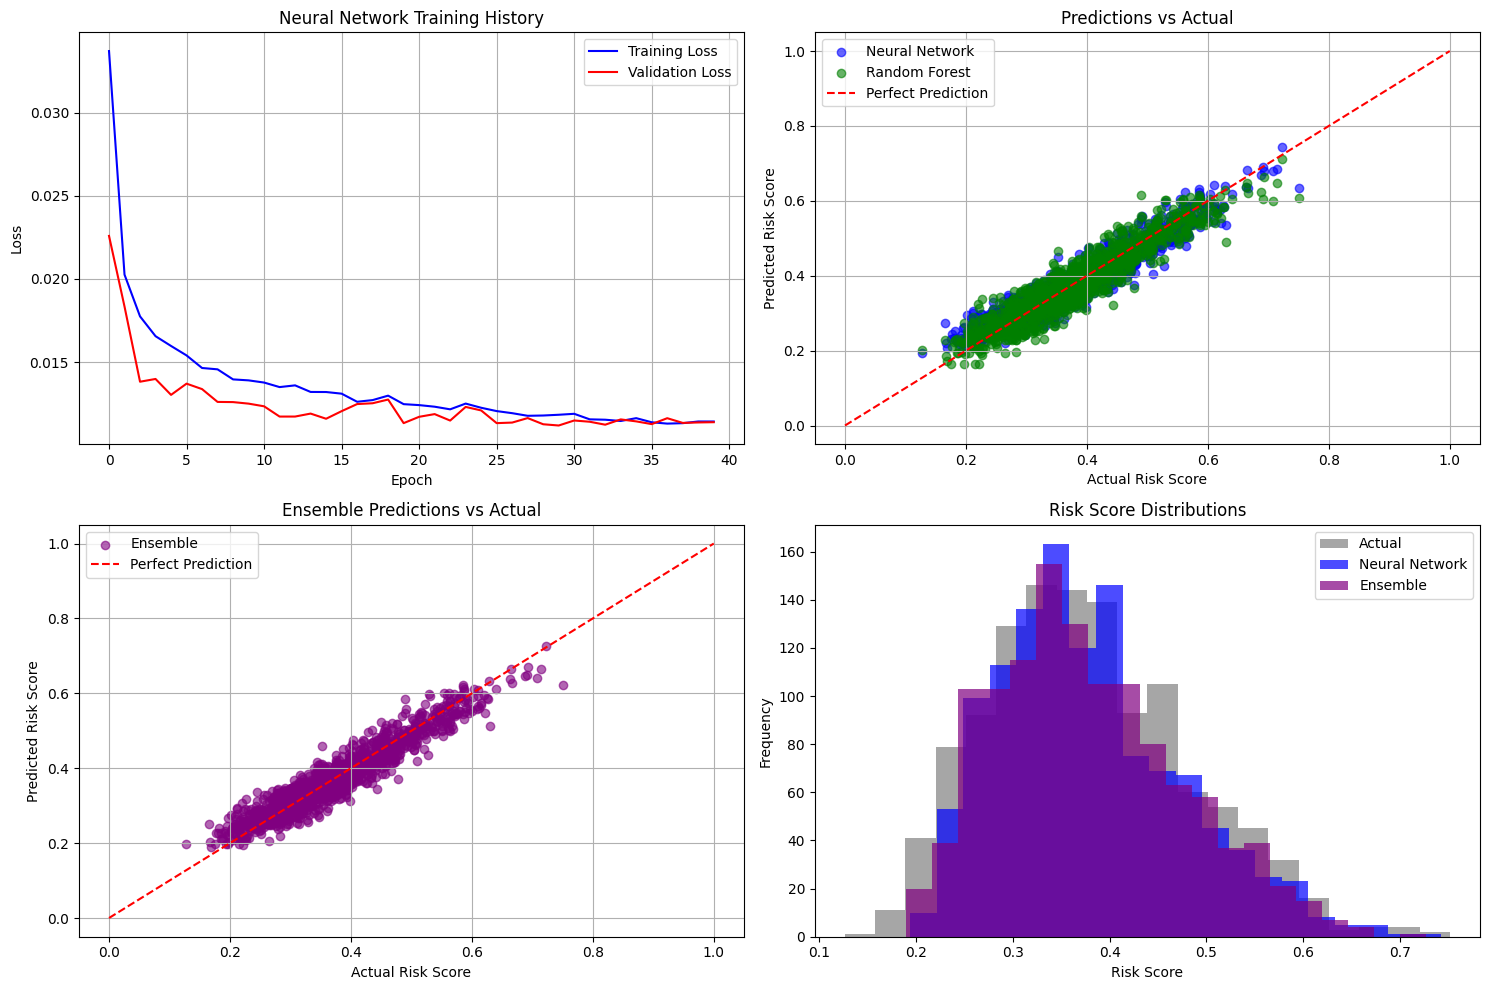


EXAMPLE PREDICTIONS
LOW RISK TOURIST (30yo Indian Male, Group of 3, Safe location):
  Risk Score: 0.221
  Risk Level: LOW
  Top Recommendation: Follow standard safety precautions

HIGH RISK TOURIST (22yo Foreign Female, Solo, High-risk location, Night time):
  Risk Score: 0.674
  Risk Level: MODERATE
  Recommendations: Stay vigilant and aware of surroundings, Keep someone informed of your itinerary



MODERATE RISK TOURIST (45yo Indian Female, Pair, Moderate location, Health condition):
  Risk Score: 0.427
  Risk Level: MODERATE
  Key Risk Factors: Gender=Moderate, Health=High
Models saved with prefix: india_tourist_safety_profiler

INTEGRATION GUIDE

USAGE IN YOUR SYSTEM:

1. For real-time risk assessment:
    tourist_data = {
        'age': user_age,
        'gender': user_gender, 
        'group_size': user_group_size,
        'location_safety_score': location_model_output,  # From your location model
        'health_conditions': user_health_list,
        'visit_time': current_time,
        'is_foreign': user_is_foreign
    }
    
    risk_result = profiler.predict_tourist_risk(tourist_data)
    static_safety_score = risk_result['static_risk_score']

2. Integration with dynamic model:
    # Combine static and dynamic scores   
    dynamic_score = lstm_model.predict(gps_sequence, context)['dynamic_safety_score']
    static_score = profiler.predict_tourist_risk(tourist_data)['stat

In [ ]:

# Example usage and testing

# Initialize the model
profiler = IndiaTouristSafetyProfiler()

# Train the model
print("Training India Tourist Safety Profile Model...")
history, X_test, y_test, nn_pred, rf_pred, ensemble_pred = profiler.train_model(n_samples=6000)

# Example predictions
print("\n" + "="*60)
print("EXAMPLE PREDICTIONS")
print("="*60)

# Example 1: Low risk tourist
tourist1 = {
    'age': 30,
    'gender': 'Male',
    'group_size': 3,
    'location_safety_score': 0.25,  # Safe location like Goa
    'health_conditions': ['none'],
    'is_foreign': False
}

result1 = profiler.predict_tourist_risk(tourist1)
print("LOW RISK TOURIST (30yo Indian Male, Group of 3, Safe location):")
print(f"  Risk Score: {result1['static_risk_score']:.3f}")
print(f"  Risk Level: {result1['risk_level']}")
print(f"  Top Recommendation: {result1['recommendations'][0]}")

# Example 2: High risk tourist
tourist2 = {
    'age': 22,
    'gender': 'Female',
    'group_size': 1,
    'location_safety_score': 0.75,  # High risk location like remote trek
    'health_conditions': ['asthma'],
    'is_foreign': True
}

result2 = profiler.predict_tourist_risk(tourist2)
print("\nHIGH RISK TOURIST (22yo Foreign Female, Solo, High-risk location, Night time):")
print(f"  Risk Score: {result2['static_risk_score']:.3f}")
print(f"  Risk Level: {result2['risk_level']}")
print(f"  Recommendations: {', '.join(result2['recommendations'][:2])}")

# Example 3: Moderate risk tourist
tourist3 = {
    'age': 45,
    'gender': 'Female',
    'group_size': 2,
    'location_safety_score': 0.40,  # Moderate risk location
    'health_conditions': ['diabetes'],
    'is_foreign': False
}

result3 = profiler.predict_tourist_risk(tourist3)
print("\nMODERATE RISK TOURIST (45yo Indian Female, Pair, Moderate location, Health condition):")
print(f"  Risk Score: {result3['static_risk_score']:.3f}")
print(f"  Risk Level: {result3['risk_level']}")
print(f"  Key Risk Factors: Gender={result3['risk_factors']['gender_factor']}, Health={result3['risk_factors']['health_factor']}")

# Save the model
profiler.save_model('india_tourist_safety_profiler')

print("\n" + "="*60)
print("INTEGRATION GUIDE")
print("="*60)
print("""
USAGE IN YOUR SYSTEM:

1. For real-time risk assessment:
    tourist_data = {
        'age': user_age,
        'gender': user_gender,
        'group_size': user_group_size,
        'location_safety_score': location_model_output,  # From your location model
        'health_conditions': user_health_list,
        'visit_time': current_time,
        'is_foreign': user_is_foreign
    }

    risk_result = profiler.predict_tourist_risk(tourist_data)
    static_safety_score = risk_result['static_risk_score']

2. Integration with dynamic model:
    # Combine static and dynamic scores
    dynamic_score = lstm_model.predict(gps_sequence, context)['dynamic_safety_score']
    static_score = profiler.predict_tourist_risk(tourist_data)['static_risk_score']

    final_score = 0.3 * static_score + 0.7 * dynamic_score

3. Model handles:
    - Age: 18-100 years
    - Gender: 'Male' or 'Female'
    - Group size: 1-10 people
    - Location safety: 0.0 (safest) to 1.0 (most dangerous)
    - Health conditions: List of conditions or ['none']
    - Visit time: 'HH:MM' format
    - Tourist type: Indian (False) or Foreign (True)
""")

print("Model training complete and ready for deployment!")